<a href="https://colab.research.google.com/github/clareyan/1009/blob/main/(Answer)_ML_L1_3_Classification_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 - Titanic survival prediction

## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression

## 2. Read csv and inspect

In [ ]:
df = pd.read_csv('https://drive.google.com/u/1/uc?id=1MgPFxypNk6XwdAMfI4k32Q2o6TNzzPpB&export=download')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Brainstorm** Shall we first perform train test split or feature engineering?

## 3. Split the data into training set and testing set

In [ ]:
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,salutation
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,Mr
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S,Mr
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S,Mr
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,Mr
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss


## 4. Data transformation and cleansing

From this point onwards, we will perform feature engineering on `X_train`.

**Brainstorm**: We modify `X_train` but not the original dataframe, why?

### 4.1 Extract salutation from Name

One hypothesis is that the salutation (Mr., Miss., etc) has some indication of the survival rate.

**Task:** Extract the salutation
1. Loop through all values in the `Name` column using `.apply()` of a series
2. Using the `.split()` function of string, split the name into two parts by comma, then get the later part of the Name (e.g. Mr. Austen, Mr. William John)
3. Using the `.split()` function again, split by dot, then get the first part.
4. Use `strip()` to make sure no extra white spaces.

In [ ]:
X_train['salutation'] = X_train['Name'].apply(lambda name:name.split(',')[1].split('.')[0].strip())

### 4.2 Drop unnecessary columns

Let's assume some columns are useless that we can drop them:

- Name
- PassengerId
- Ticket
- Cabin

**Brainstorm**: Can we train the model using PassgenerId?

In [ ]:
X_train = X_train.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1)

### 4.3 Check for missing values

`isnull()` is used to check if a value is null in a dataframe or series.

- `df.isnull()` returns a boolean dataframe
- `series.isnull()` returns a boolean series

During summation (+), `True` is treated as 1 and `False` is treated as 0.  Thus, `df.isnull().sum()` give us a summary on how many null values are there.

**Task**
1. Use `.isnull()` to check is it a null for each value in `X_train`
2. Use `.sum()` to count number of null values in each column

In [ ]:
X_train.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
salutation    0
dtype: int64

### 4.4 Filling missing values

In previous step, we found that there a lot of missing values in the `Age` column.

Assume we wish to fill the missing values with the average `Age` for each `Pclass` separately.

**Task**
1. Calculate the average age for each Pclass
2. Fill the null values accordingly

In [ ]:
mean_of_pclass = X_train.groupby('Pclass')['Age'].mean()
mean_of_pclass

Pclass
1    37.933060
2    29.846201
3    25.156754
Name: Age, dtype: float64

In [ ]:
X_train.loc[(X_train['Age'].isnull())&(X_train['Pclass']==1),'Age'] = mean_of_pclass[1]
X_train.loc[(X_train['Age'].isnull())&(X_train['Pclass']==2),'Age'] = mean_of_pclass[2]
X_train.loc[(X_train['Age'].isnull())&(X_train['Pclass']==3),'Age'] = mean_of_pclass[3]

Also from the previous step, there are 2 null values in `Embarked`.  Since there are only 2 of them, we can either drop them or fill them with the most common value from `Embarked`.

Steps:
1. Use `.mode()` to find most common value
2. Use `.fillna()` to fill

In [ ]:
most_common_embarked = X_train.Embarked.mode()
most_common_embarked

0    S
Name: Embarked, dtype: object

In [ ]:
X_train.Embarked.fillna(most_common_embarked[0],inplace=True)

In [ ]:
# Check that df.Embarked contains no null.

X_train.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

### 4.5 Transform categorical features using One Hot Encoding; standardize numberical feature

In [ ]:
# ------------------------
# Numerical variable
X_train_numerical = X_train[['Age', 'SibSp', 'Parch', 'Fare']]

standardScaler = StandardScaler(with_mean=False)
X_train_numerical = standardScaler.fit_transform(X_train_numerical) # Output is a numpy array, not pandas df

# ------------------------
# Categorical variable
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(X_train[['Sex', 'Embarked', 'Pclass', 'salutation']])
X_train_ohe_features = enc.transform(X_train[['Sex', 'Embarked', 'Pclass', 'salutation']]) # Output is a numpy array, not pandas df

In [ ]:
# Meaning of each column in one hot features

np.concatenate(enc.categories_)

array(['female', 'male', 'C', 'Q', 'S', 1, 2, 3, 'Capt', 'Col', 'Dr',
       'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs',
       'Ms', 'Rev', 'the Countess'], dtype=object)

In [ ]:
# Put it back into a dataframe
# This step is for display only, optional

one_hot_features_df = pd.DataFrame(X_train_ohe_features, columns=np.concatenate(enc.categories_), index=X_train.index)
one_hot_features_df

,female,male,C,Q,S,1,2,3,Capt,Col,...,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,the Countess
331,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
733,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
382,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
704,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
813,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
860,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
435,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Combine numerical variable and categorical variable in numpy
X_train_ready = np.hstack([X_train_numerical, X_train_ohe_features])

In [ ]:
X_train_ready

array([[3.45415629, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.74605702, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.42929673, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.11253644, 1.70129115, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.06281732, 0.85064557, 2.52808329, ..., 0.        , 0.        ,
        0.        ],
       [1.59422598, 0.        , 1.26404165, ..., 0.        , 0.        ,
        0.        ]])

## 5. Logistic Regression Model

In [ ]:
logmodel= LogisticRegression()
logmodel.fit(X_train_ready,y_train)

LogisticRegression()

## 6. Evaluation

### 6.1 Feature engineering for testing set

In [ ]:
# Feature engineering for testing set
# Most of them repeat training set, but do NOT fit again

# Salutation
X_test['salutation'] = X_test['Name'].apply(lambda name:name.split(',')[1].split('.')[0].strip())

# Fill null for Age -- Do not calculate mean again
X_test.loc[(X_test['Age'].isnull())&(X_test['Pclass']==1),'Age'] = mean_of_pclass[1]
X_test.loc[(X_test['Age'].isnull())&(X_test['Pclass']==2),'Age'] = mean_of_pclass[2]
X_test.loc[(X_test['Age'].isnull())&(X_test['Pclass']==3),'Age'] = mean_of_pclass[3]

# Fill null for Embarked -- Do not calculate most common embarked again
X_test.Embarked.fillna(most_common_embarked[0],inplace=True)

# Numerical variable -- Use the previous standard scaler
X_test_numerical = X_test[['Age', 'SibSp', 'Parch', 'Fare']]
X_test_numerical = standardScaler.transform(X_test_numerical)

# Categorical variable - Use the previous one hot encoder
X_test_ohe_features = enc.transform(X_test[['Sex', 'Embarked', 'Pclass', 'salutation']])

# Concat
X_test_ready = np.hstack([X_test_numerical, X_test_ohe_features])

y_pred = logmodel.predict(X_test_ready)

### 6.2 Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
log_test=accuracy_score(y_test,y_pred)
log_train=accuracy_score(y_train,logmodel.predict(X_train_ready))

In [ ]:
print("Accuracy of logistic_test: %.2f%%" % (log_test* 100.0))
print("Accuracy of logistic_train: %.2f%%" % (log_train* 100.0))

Accuracy of logistic_test: 81.01%
Accuracy of logistic_train: 83.71%


### 6.3 Coefficients importance

We wish to analyse the importance of each variable - which one has a higher implication to the result.

Since highly positive and highly negative impact are what we are looking for, we will order the that using the absolute values.

**Task** Get the feature importance and visualize
1. Get the importance from `model.coef_`
2. Put the result into a dataframe, accompanied by feature names
3. Color the dataframe with `df.style.bar`

In [ ]:
logmodel.coef_[0] #returns a 1D array of shape (n_features,)

array([-0.30728548, -0.54636453, -0.29007207,  0.2577544 ,  0.93127473,
       -0.93107724,  0.22971043,  0.02881162, -0.25832456,  0.74568942,
        0.17221879, -0.91771072, -0.22107608, -0.03850552, -0.29937857,
        0.10528425, -0.02767282,  1.70848032, -0.30060529,  0.0759359 ,
        0.03760231, -1.13496334,  0.81777096,  0.12979599, -0.91796122,
        0.0654906 ])

In [ ]:
# Getting the coefficients
coefficients = logmodel.coef_[0]

# Matching coefficients to features
features = ['Age', 'SibSp', 'Parch', 'Fare'] + list(enc.get_feature_names_out())

# Create a DataFrame with coefficients
coef_df = pd.DataFrame({
    'variable': features,
    'coefficient': logmodel.coef_[0]
}).sort_values('coefficient', ascending=False, key=abs).head(10)

# Display coefficients as a bar plot in DataFrame
coef_df.style.bar(color=['red', 'lightblue'], align='zero')

,variable,coefficient
17,salutation_Master,1.708480
21,salutation_Mr,-1.134963
4,Sex_female,0.931275
5,Sex_male,-0.931077
24,salutation_Rev,-0.917961
11,Pclass_3,-0.917711
22,salutation_Mrs,0.817771
9,Pclass_1,0.745689
1,SibSp,-0.546365
0,Age,-0.307285




- a positive coefficient for the 'Fare' feature would suggest that higher fares are associated with higher odds of survival.

- a negative coefficient for the 'Age' feature would suggest that older passengers had lower odds of survival.

## 7. Redo with Decision Tree Model

### 7.1 Training

Let's repeat the exercise with decision tree.

Steps
1. Create and train a `DecisionTreeClassifier`
2. No need to repeat the feature engineering part, just modeling

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=4)
dtree.fit(X_train_ready, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
dtree_pred=dtree.predict(X_test_ready)

In [ ]:
from sklearn.metrics import accuracy_score
dtree_test=accuracy_score(y_test,dtree_pred)
dtree_train=accuracy_score(y_train,dtree.predict(X_train_ready))

In [ ]:
print("Accuracy of dtree_test: %.2f%%" % (dtree_test* 100.0))
print("Accuracy of dtree_train: %.2f%%" % (dtree_train* 100.0))

Accuracy of dtree_test: 82.12%
Accuracy of dtree_train: 83.85%


### 7.2 Evaluation - Decision Tree Plot

It is nice to plot the decision tree so that we know what is really going on there.

Step
1. import the `plot_tree` function from `sklearn.tree`
2. Pass the decision tree model to the `plot_tree()` function, note that we have to supply `feature_names` and `class_names`

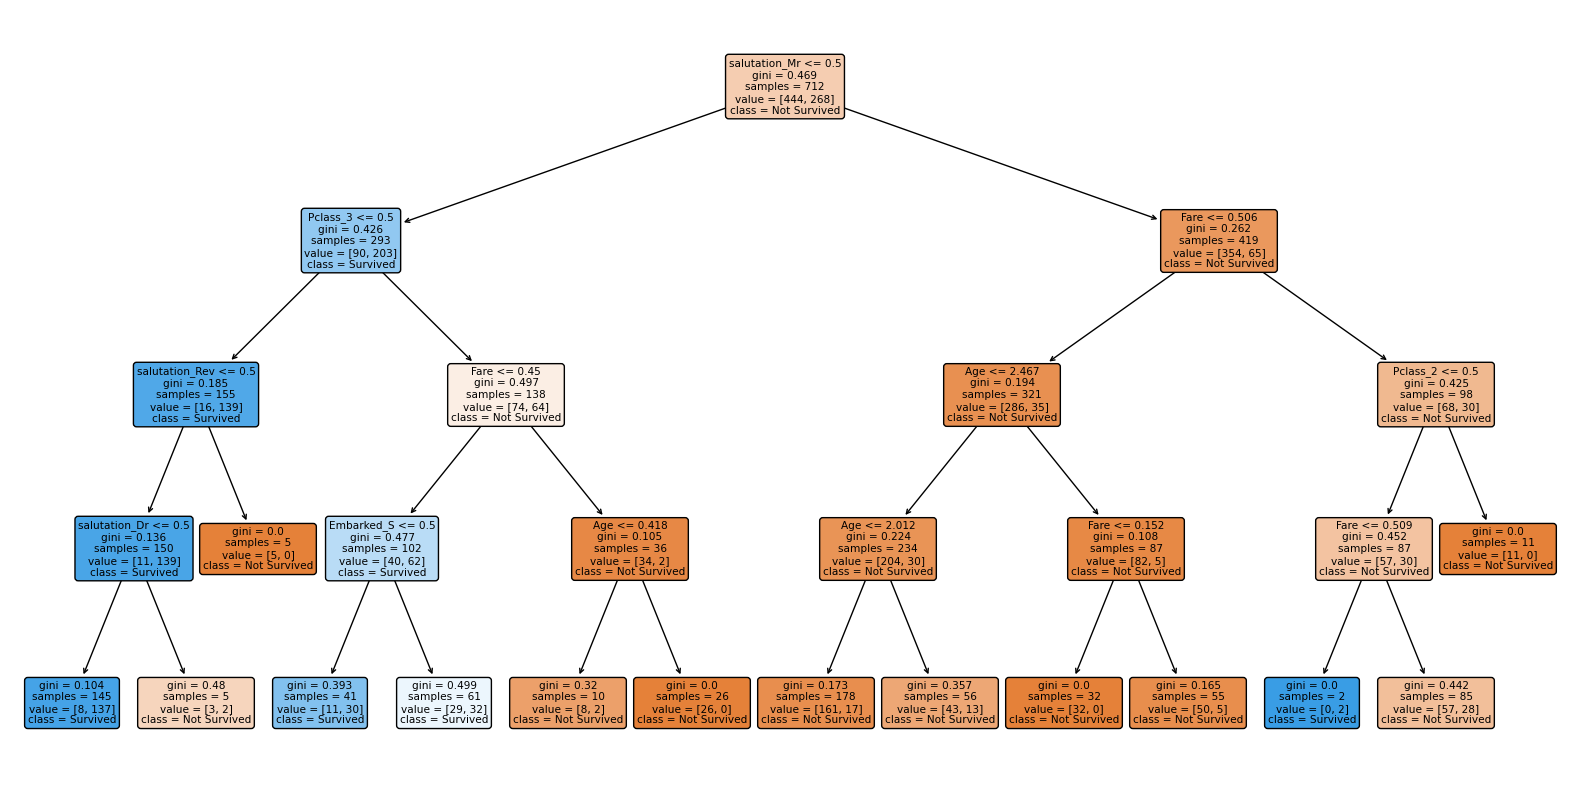

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dtree, filled=True, feature_names=features, class_names=["Not Survived", "Survived"], rounded=True)
plt.show()